LEGI = 19917558

# SLT-CE-3: Histogram Clustering

In this coding exercise, you will segment an image with histogram clustering (HC). You will implement two different methods: maximum a posterior probability (MAP) and deterministic annealing (DA) for predicting the cluster membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981 

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture05.pdf

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf, chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [100]:
import sklearn as skl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import random

from sklearn.feature_extraction import image
from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread
import scipy as sp
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from skimage.util.shape import view_as_windows
from scipy.signal import convolve2d
import seaborn as sns
import itertools
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

## Texture and corresponding label map
(This texture is used to fit your model.)

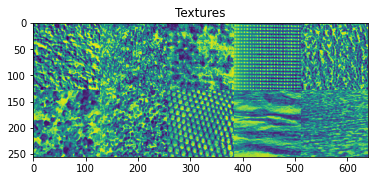

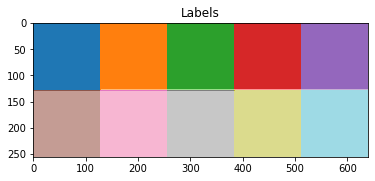

In [101]:
texture = imread("texture.png")

patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

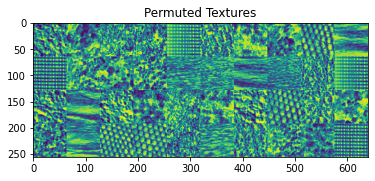

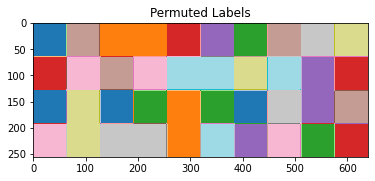

In [102]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both: maximum a posteriori probability estimation (MAP) and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> looks for the case of DA (using the notation of reference [1]).<br>
Hint: try to derive $\hat P(y|c)$ from $\hat P(c|x)$ and use the maximum entropy principle to find $\hat P(c|x)$.
</p>


To compute the parameters estimation with MAP, we use the following formulas from [1]:

* Features given centroids (eq 5 of [1]): $ \hat P(y | c) = \sum_{x: \hat c(x) = c} \frac{n(x)}{\sum_{x': \hat c(x') = c)} n(x')} \hat P(y | x) .$

* Centroids asssignments (eq 6 of [1]) assuming a uniform prior $P(c)$ can be calculated in one step: $\hat{c}(x) = \arg\min_a \left( -\sum_{y\in Y} \hat{P}(y|x)\log\hat{P}(y|a) \right)$. 
    
In the case of DA, equation (5) becomes $\hat{P}(y|c) = \frac{\sum_{x \in \mathcal X} \hat P(y|x) P_{xc}}{\sum_{x \in \mathcal X} P_{xc}}$, where ${P}_{xc} = \frac{\exp(-KL(\hat{P}(y|x) || \hat{P}(y|c))/T)}{\sum_{k=1}^K \exp(-KL(\hat{P}(y|x) || \hat{P}(y|k))/T)}$. Here $KL(\hat{P}(y|x) || \hat{P}(y|c))$ denote  the Kullback-Leibler divergence between $\hat{P}(y|x)$ and $\hat{P}(y|c))$ which is calculated as $KL(\hat{P}(y|x) || \hat{P}(y|c)) = \sum_{i=1}^n \hat{P}(y_i|x) \log\frac{\hat{P}(y_i|x)}{\hat{P}(y_i|c)}$ (assuming that $y$ has dimension $n$). 

In [377]:

def maps_matching(ground_map, train_map, n_clusters):
    flat_ground_map = ground_map.ravel()
    flat_train_map = train_map.ravel()
    
    ids = {c: np.where(flat_train_map == c)[0] for c in range(n_clusters)}
    intersection_matching = np.array([[np.intersect1d(ids[c], np.where(flat_ground_map == r)[0]).size for r in range(n_clusters)] for c in range(n_clusters)])
    
    new_map = {}
    while np.any(intersection_matching):
        maximum_matching = np.unravel_index(intersection_matching.argmax(), intersection_matching.shape)
        new_map[maximum_matching[0]] = maximum_matching[1]
        intersection_matching[maximum_matching[0], :] = 0
        intersection_matching[:, maximum_matching[1]] = 0
    
    def get_value(key):
        if key in new_map:
            return new_map[key]
        else:
            return key
        
    return np.vectorize(get_value)(train_map), {v: k for k, v in new_map.items()}


def plot_confusion_matrix(y_true, y_pred, labels = np.arange(10), figsize=(7, 7), title = "Confusion Matrix"):

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Permute the labels using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-cm)
    cm_permuted = cm[row_ind[:, np.newaxis], col_ind]

    cell_size = 1.5 if len(labels) < 10 else .85

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        cm_permuted, annot=True, fmt="d", cmap="Reds", cbar=True, ax=ax,
        square=True, cbar_kws={"shrink": 0.8}, linewidths=1, linecolor='gray',
        annot_kws={"size": cell_size*12}
    )

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    ax.set_xticklabels(labels[col_ind], rotation=45, ha="right")
    ax.set_yticklabels(labels[row_ind], rotation=0)

    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel('Number of samples', rotation=270, labelpad=15)

    ax.set_title(title)

    plt.show()

In [378]:

class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        cluster_centers (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=128, window_size=15, random_state=42, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins = n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
    
    def patch_extraction(self, X, window_size = None):
        patch = window_size if window_size is not None else self.window_size
        n_pad = (patch-1)//2
        patch_grid = (patch, patch)

        X_padded = np.pad(X, pad_width = ((n_pad,n_pad),(n_pad,n_pad)), mode = 'constant', constant_values= -1)
        return image.extract_patches_2d(X_padded, patch_grid)

    def histograms(self, patch):
        masked_patch = patch[patch>=0]
        hist = np.histogram(masked_patch, bins=np.linspace(0,1,self.n_bins+1))[0]
        return hist/np.sum(hist)

    def fit(self, X, X_test = None):
        """Compute HC for input image X
        
        Compute cluster_centers.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """
        n_pixels = X.shape[0] * X.shape[1]
        patches = self.patch_extraction(X).reshape(n_pixels, -1)
        p_y_mid_x = sp.sparse.csr_matrix(np.apply_along_axis(self.histograms, arr = patches, axis = 1))

        self.posterior_histograms = p_y_mid_x

        #MAP
        if self.estimation == "MAP":
            
            self.cluster_centers = np.random.rand(self.n_clusters, self.n_bins)
            self.cluster_centers /= self.cluster_centers.sum(axis=1, keepdims=True)

            assignments = np.argmin(-p_y_mid_x.dot(np.log(self.cluster_centers).T), axis=-1)

            while True:

                old_ass = assignments.copy()

                # 5) Calculate P_y_mid_c
                for cid in range(self.n_clusters):
                    self.cluster_centers[cid] = np.mean(p_y_mid_x[assignments == cid], axis=0)

                #Numerical stability
                self.cluster_centers += 1e-8

                # 6) Calcualte hat_c_x
                assignments =np.argmin(-p_y_mid_x.dot(np.log(self.cluster_centers).T), axis=-1)

                if np.sum(assignments - old_ass) == 0:
                    break

            self.cluster_centers /= self.cluster_centers.sum(axis=1, keepdims=True)


        #DA
        elif self.estimation == "DA":
            p_y_mid_x = p_y_mid_x.toarray()

            if X_test is not None:
                test_patches = self.patch_extraction(X_test).reshape(n_pixels, -1)
                test_histogram = (np.apply_along_axis(self.histograms, arr = test_patches, axis = 1))
            else:
                print("Required permuted labels texture for the plot of DA as a function of the temperature")
                return self


            # Initialize cluster_centers
            self.cluster_centers = np.broadcast_to(np.mean(p_y_mid_x, axis = 0), (self.n_clusters,) + (self.n_bins,)).copy()
            self.cluster_centers /= self.cluster_centers.sum(axis=1, keepdims=True)
            
            # Initialize probabilities
            p_x = np.full((n_pixels, self.n_clusters), 1/self.n_clusters, dtype='float32')

            # Temperature parameters
            T = 0.3
            self.T_min = 0.17
            self.T0 = 1e-2
            self.temperatures = []
            self.temperatures.append(T)

            self.imglabels = []

            while True:
                
                #Perturb cluster centers if they are too close (see skript 19)
                combs = itertools.combinations(range(self.n_clusters), 2)

                for a, b in combs:
                    diff = self.cluster_centers[a] - self.cluster_centers[b]
                    norm_diff = np.linalg.norm(diff)
            
                    if norm_diff < 1e-3:
                        noise = np.random.normal(scale=1e-3, size=self.cluster_centers[j].shape )
                        self.cluster_centers[b]  += noise
                        self.cluster_centers[b] = np.clip(self.cluster_centers[b], 0, 1)

                self.cluster_centers /= self.cluster_centers.sum(axis=1, keepdims=True)
                
                while True:
                    
                    old_centers = self.cluster_centers.copy()
                    
                    # Expectation step (KL DIV)
                    log_term_kldiv = np.log(p_y_mid_x[:, None, :] / (self.cluster_centers[None, :, :] + 1e-3) + 1e-9)
                    kl_divergence = np.einsum('ijk,ik->ij', log_term_kldiv, p_y_mid_x)
                    kl_exp = np.exp((-kl_divergence / T).T)
                    p_x = (kl_exp / np.sum(kl_exp, axis=0)).T

                    # Maximization step
                    self.cluster_centers = ((p_x.T) @ p_y_mid_x) / (np.sum(p_x, axis=0, keepdims=True).T)
                    self.cluster_centers /= self.cluster_centers.sum(axis=1, keepdims=True)
                    
                    if np.linalg.norm(old_centers - self.cluster_centers) < 1e-4:
                        break

                # Append for plot of temperature
                prediction_permuted = self.predict(X, test_histogram, T=T)
                matched_preds, none = maps_matching(perm_label_map, prediction_permuted, 10)
                self.imglabels.append(matched_preds)

                #Check for last iteration
                if T == self.T0:
                    self.temperatures.append(T)
                    return self
                
                #Perform last iteration if temperature is below T_min
                if T < self.T_min:
                    T = self.T0
                
                #Cooling step
                else:
                    T *= 0.9
                    self.temperatures.append(T) 

        return self

    def predict(self, X, p_y_mid_x=None, T=None):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["cluster_centers"])
        n_pixels = X.shape[0] * X.shape[1]

        
        if p_y_mid_x is None:
            patches = self.patch_extraction(X).reshape(n_pixels, -1)
            p_y_mid_x = sp.sparse.csr_matrix(np.apply_along_axis(self.histograms, arr = patches, axis = 1))
            self.posterior_histograms = p_y_mid_x

        if self.estimation == "MAP":
            assignments =  np.argmin(-p_y_mid_x.dot(np.log(self.cluster_centers).T), axis=-1)
            
        if self.estimation == "DA":
            assert T is not None
            log_term_kldiv = np.log(p_y_mid_x[:, None, :] / (self.cluster_centers[None, :, :] + 1e-3) + 1e-9)
            kl_divergence = np.einsum('ijk,ik->ij', log_term_kldiv, p_y_mid_x)
            kl_exp = np.exp((-kl_divergence / T).T)
            p_x = (kl_exp / np.sum(kl_exp, axis=0)).T
            assignments = np.argmax(p_x, axis=1)

        return np.reshape(assignments, (X.shape[0], X.shape[1]))

    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["cluster_centers"])

        X = np.zeros(C.shape)
        height, width = C.shape
        discretization = np.linspace(0, 1, self.n_bins+1)
        
        for i in range(height * width):
            h, w = divmod(i, width)
            cumsum_clusters = np.cumsum(self.cluster_centers[C[h,w]])
            choice = random.random()
            bin = np.searchsorted(cumsum_clusters, choice)
            X[h,w] = np.random.uniform(discretization[bin],discretization[bin+1],1)

        return X
 
        

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [353]:
%%time
HC = HistogramClustering()
HC.fit(texture)
check_is_fitted(HC, ["cluster_centers"])

CPU times: user 17.4 s, sys: 1.17 s, total: 18.6 s
Wall time: 18.6 s


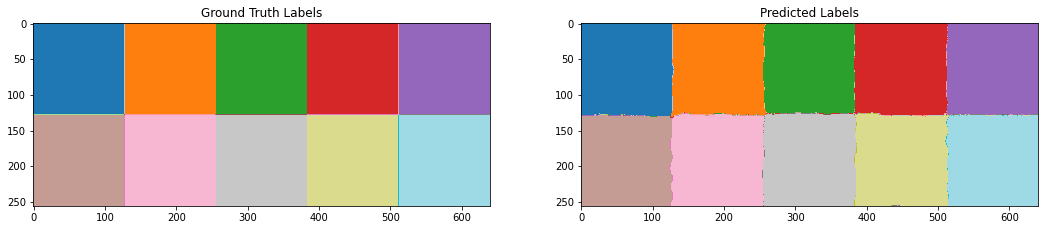

Train Accuracy: 98.98 %


In [354]:
train_predictions = HC.predict(texture, HC.posterior_histograms)

matching, none = maps_matching(label_map, train_predictions, 10)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].imshow(label_map, cmap="tab20")
axs[0].set_title("Ground Truth Labels")

axs[1].imshow(matching, cmap="tab20")
axs[1].set_title("Predicted Labels")

plt.show()

print('Train Accuracy:', round(accuracy_score(label_map.flatten(), matching.flatten()), 4)*100, "%")

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

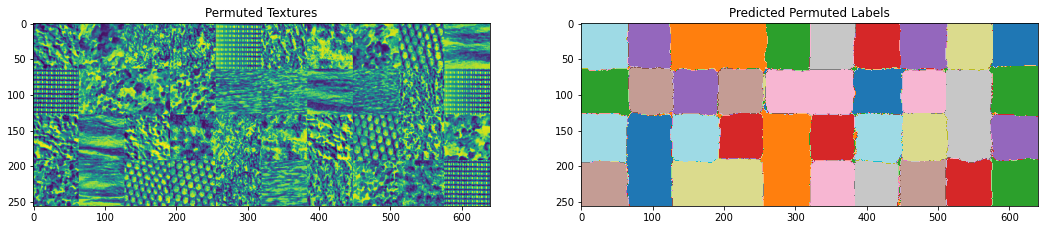

CPU times: user 13.5 s, sys: 110 ms, total: 13.6 s
Wall time: 13.5 s


In [357]:
%%time
predicted_labels = HC.predict(perm_texture)
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].imshow(perm_texture)
axs[0].set_title("Permuted Textures")

axs[1].imshow(predicted_labels, cmap="tab20")
axs[1].set_title("Predicted Permuted Labels")

plt.show()

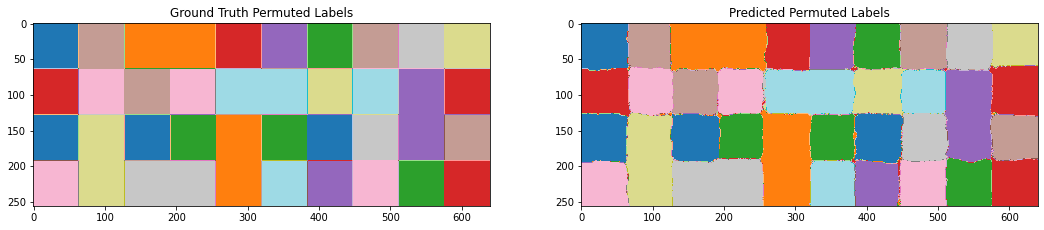

In [108]:
matched_preds, none = maps_matching(perm_label_map, predicted_labels, 10)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].imshow(perm_label_map, cmap="tab20")
axs[0].set_title("Ground Truth Permuted Labels")

axs[1].imshow(matched_preds, cmap="tab20")
axs[1].set_title("Predicted Permuted Labels")

plt.show()


<p style="background-color:#adebad;">
    Plot the confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, to make them correspond to the true labels (see Hungarian algortihm to find the best match).
</p>

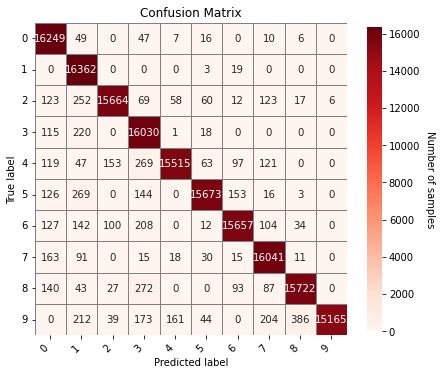

Train Accuracy: 96.48 %


In [109]:
plot_confusion_matrix(perm_label_map.flatten(), matched_preds.flatten())

print('Train Accuracy:', round(accuracy_score(perm_label_map.flatten(), matched_preds.flatten()), 4)*100, "%")

<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [110]:
n_bins = [16,32,64]
window_sizes = [7,9,11]
param_combinations = list(itertools.product(n_bins, window_sizes))

results = []
accuracy_matrix = np.zeros((len(window_sizes), len(n_bins)))

for i, (n_bin, window_size) in enumerate(param_combinations):
    HC = HistogramClustering(n_bins=n_bin, window_size=window_size)
    HC.fit(texture)

    predicted_labels = HC.predict(perm_texture)
    matched_preds, none = maps_matching(perm_label_map, predicted_labels, 10)

    accuracy_matrix[i // len(n_bins), i % len(n_bins)] = accuracy_score(perm_label_map.flatten(), matched_preds.flatten())
    results.append([n_bin, window_size, matched_preds])


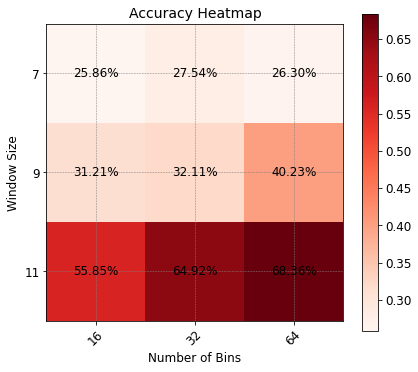

In [111]:
fig, ax = plt.subplots(figsize=(6, 6))

cmap = "Reds"
im = ax.imshow(accuracy_matrix, cmap=cmap)
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=12)


ax.set_xticks(np.arange(len(n_bins)))
ax.set_yticks(np.arange(len(window_sizes)))
ax.set_xticklabels(n_bins, fontsize=12)
ax.set_yticklabels(window_sizes, fontsize=12)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


for i in range(len(window_sizes)):
    for j in range(len(n_bins)):
        text = ax.text(j, i, "{:.2%}".format(accuracy_matrix[i, j]), ha="center", va="center", color="black", fontsize=12)

# Set the title and axis labels
ax.set_title('Accuracy Heatmap', fontsize=14)
ax.set_xlabel('Number of Bins', fontsize=12)
ax.set_ylabel('Window Size', fontsize=12)

# Add a grid to the plot
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adjust the layout of the plot and show it
fig.tight_layout()
plt.show()

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them accordingly.
    </p>

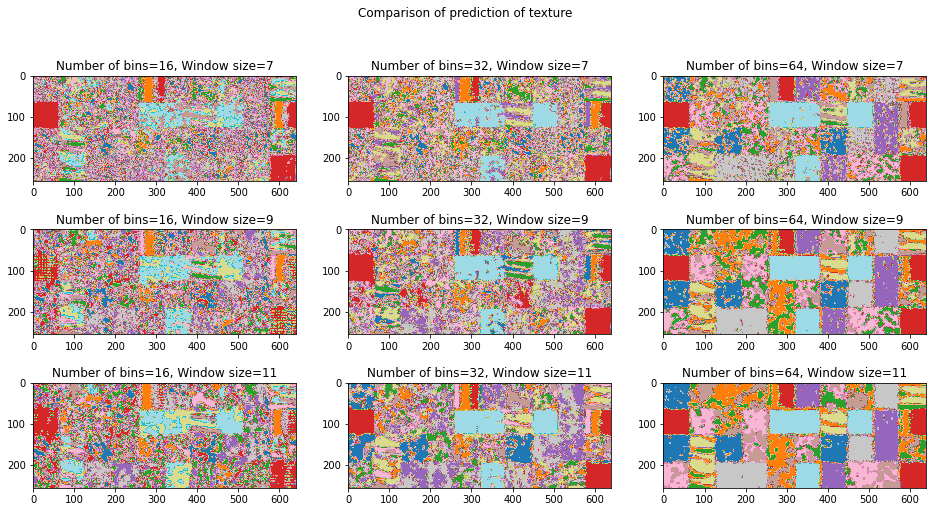

In [112]:
fig, axs = plt.subplots(3, 3, figsize=(16, 8))
fig.suptitle('Comparison of prediction of texture')

for i, result in enumerate(results):
    n_bin, window_size, matched_preds = result
    row, col = i % 3, i // 3
    axs[row, col].imshow(matched_preds, cmap='tab20')
    axs[row, col].set_title(f'Number of bins={n_bin}, Window size={window_size}')

plt.show()

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate</b> method for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

In [113]:
HC = HistogramClustering(n_bins=32)
HC.fit(texture)

HistogramClustering(n_bins=32)

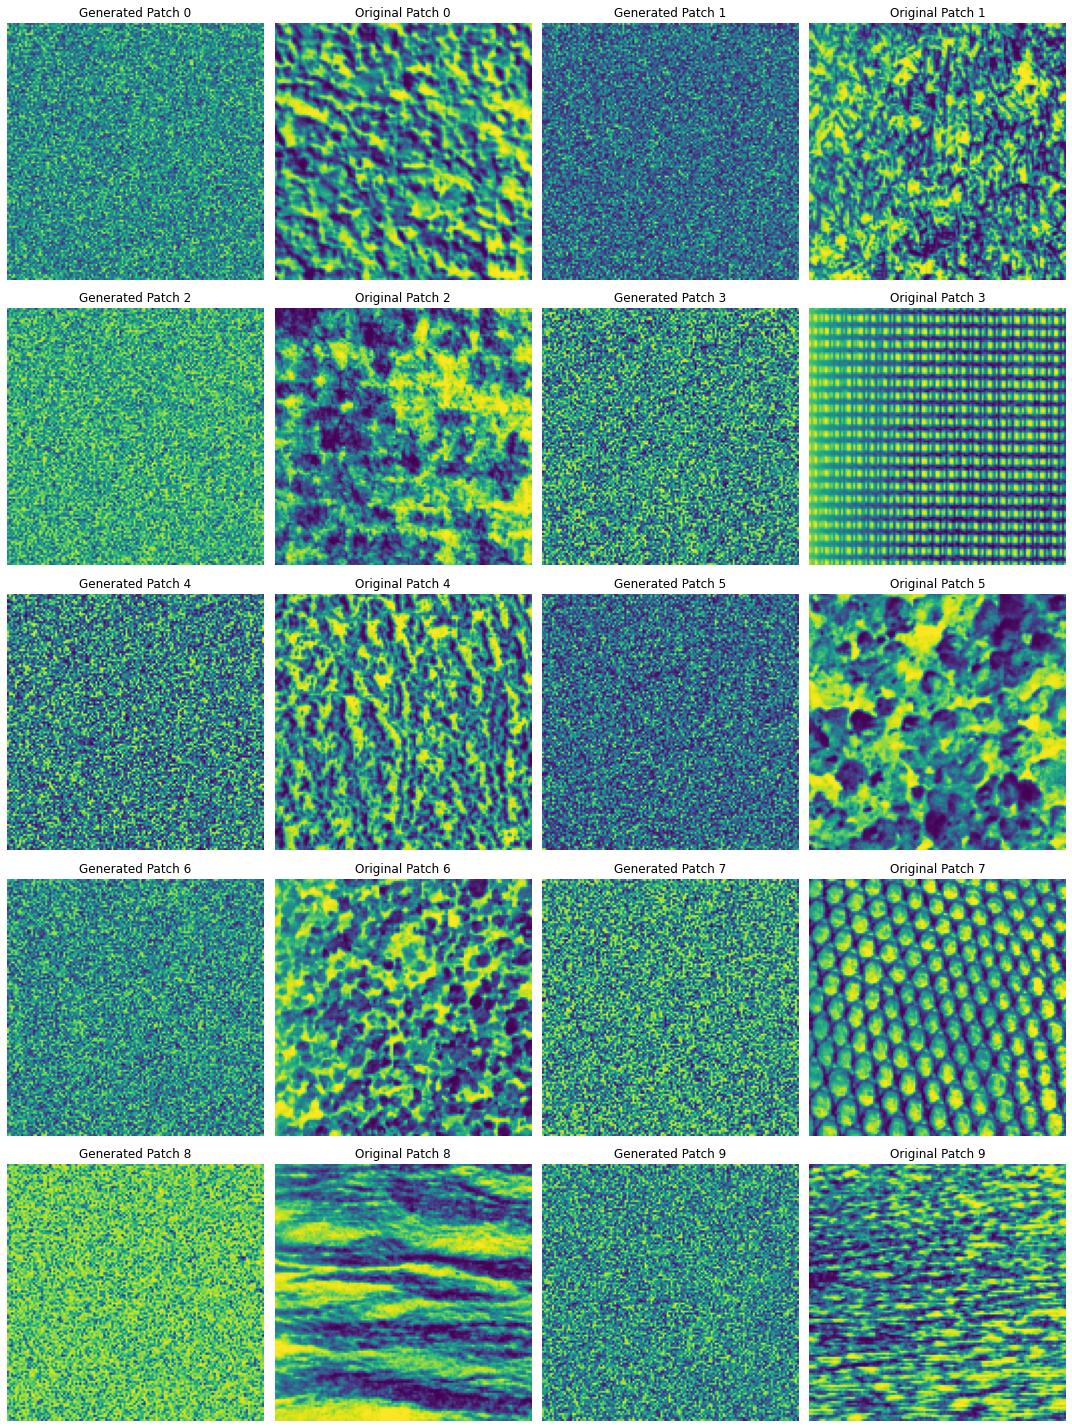

In [114]:
patches = texture.reshape(patch_grid_shape[0], patch_shape[0], patch_grid_shape[1], patch_shape[1]).transpose(0, 2, 1, 3)

originals = []
generated = []

for i, j in itertools.product(range(patch_grid_shape[0]), range(patch_grid_shape[1])):
    C = np.full(patch_shape, i * patch_grid_shape[1] + j, dtype=int)

    originals.append(patches[i, j])
    generated.append(HC.generate(C))



num_patches = len(originals)
num_rows = num_patches // 2 + num_patches % 2

fig, axs = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))

for i in range(num_patches):
    row_idx = i // 2
    col_idx = (i % 2) * 2
    axs[row_idx, col_idx].imshow(generated[i])
    axs[row_idx, col_idx].axis('off')
    axs[row_idx, col_idx + 1].imshow(originals[i])
    axs[row_idx, col_idx + 1].axis('off')
    
    axs[row_idx, col_idx].set_title('Generated Patch ' + str(i))
    axs[row_idx, col_idx + 1].set_title('Original Patch ' + str(i))
    axs[row_idx, col_idx].set_aspect('equal')
    axs[row_idx, col_idx + 1].set_aspect('equal')

fig.tight_layout()
plt.show()

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

In [115]:
HC = HistogramClustering()
HC.fit(texture)

KMEANS = KMeans(n_clusters=10, random_state=0).fit(HC.posterior_histograms)

MAPpredicted_labels = HC.predict(perm_texture)
KMEANSpredicted_labels = np.reshape(KMEANS.predict(HC.posterior_histograms), perm_label_map.shape)

MAPmatched_predictions, MAPmap = maps_matching(perm_label_map, MAPpredicted_labels, 10)
KMEANSmatched_predictions, KMEANSmap = maps_matching(perm_label_map, KMEANSpredicted_labels, 10)

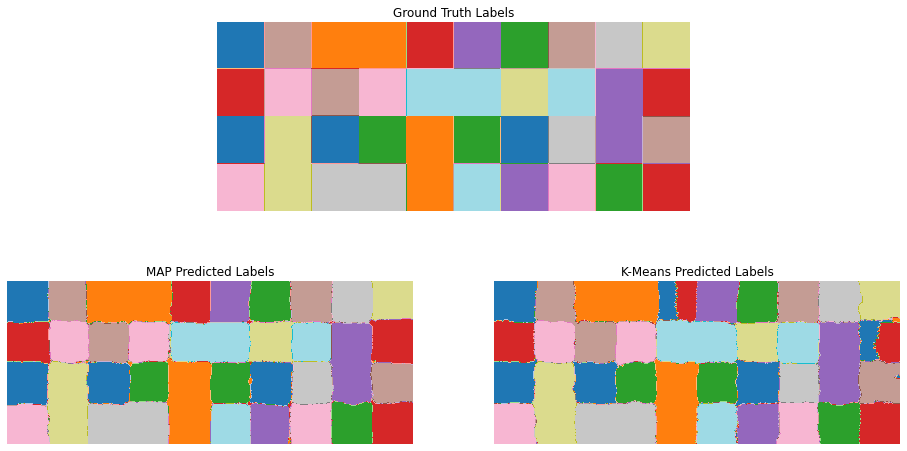

MAP Train Accuracy: 96.48 %
K-Means Train Accuracy: 95.06 %


In [116]:
fig = plt.figure(figsize=(16, 8), facecolor = "none")
gs = GridSpec(nrows=2, ncols=2, height_ratios=[1, 1], width_ratios=[2, 2], hspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
ax1.imshow(perm_label_map, cmap="tab20", aspect="equal")
ax1.set_title("Ground Truth Labels")
ax1.axis('off')

ax2 = fig.add_subplot(gs[1, 0])
ax2.imshow(MAPmatched_predictions, cmap="tab20", aspect="equal")
ax2.set_title("MAP Predicted Labels")
ax2.axis('off')

ax3 = fig.add_subplot(gs[1, 1])
ax3.imshow(KMEANSmatched_predictions, cmap="tab20", aspect="equal")
ax3.set_title("K-Means Predicted Labels")
ax3.axis('off')

plt.show()



print('MAP Train Accuracy:', round(accuracy_score(perm_label_map.flatten(), MAPmatched_predictions.flatten()), 4)*100, "%")
print('K-Means Train Accuracy:', round(accuracy_score(perm_label_map.flatten(), KMEANSmatched_predictions.flatten()), 4)*100, "%")

From the plot above we can see that both K-Means and MAP produce very similar results in term of performance

<ul style="background-color:#adebad;">
    <li>
        Plot and compare the confusion matrices for both, k-means, and HC.
    </li>
</ul>

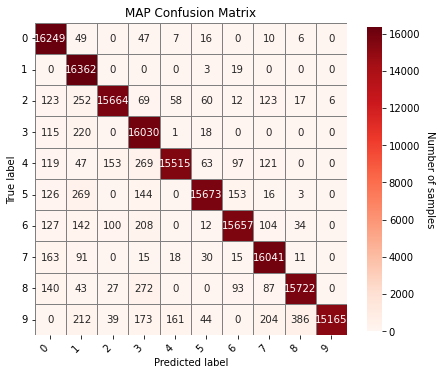

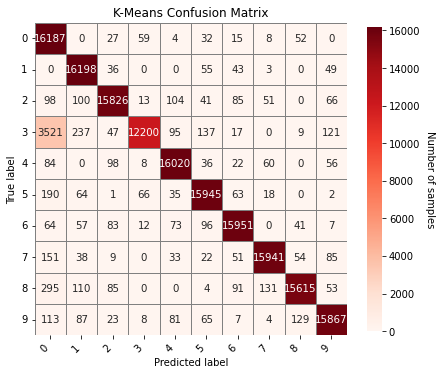

In [117]:
plot_confusion_matrix(perm_label_map.flatten(), MAPmatched_predictions.flatten(), title ="MAP Confusion Matrix")
plot_confusion_matrix(perm_label_map.flatten(), KMEANSmatched_predictions.flatten(), title ="K-Means Confusion Matrix")

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

In [118]:
patches = texture.reshape(patch_grid_shape[0], patch_shape[0], patch_grid_shape[1], patch_shape[1]).transpose(0, 2, 1, 3)

hists = {}

for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)

    original_hists = HC.histograms(patches[i, j])
    HC_hists = HC.cluster_centers[MAPmap[patch]]
    KMEANS_hists = KMEANS.cluster_centers_[KMEANSmap[patch]]

    hists[patch] = [patches[i, j], original_hists, HC_hists, KMEANS_hists]


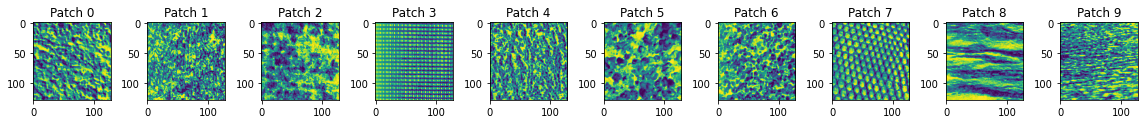

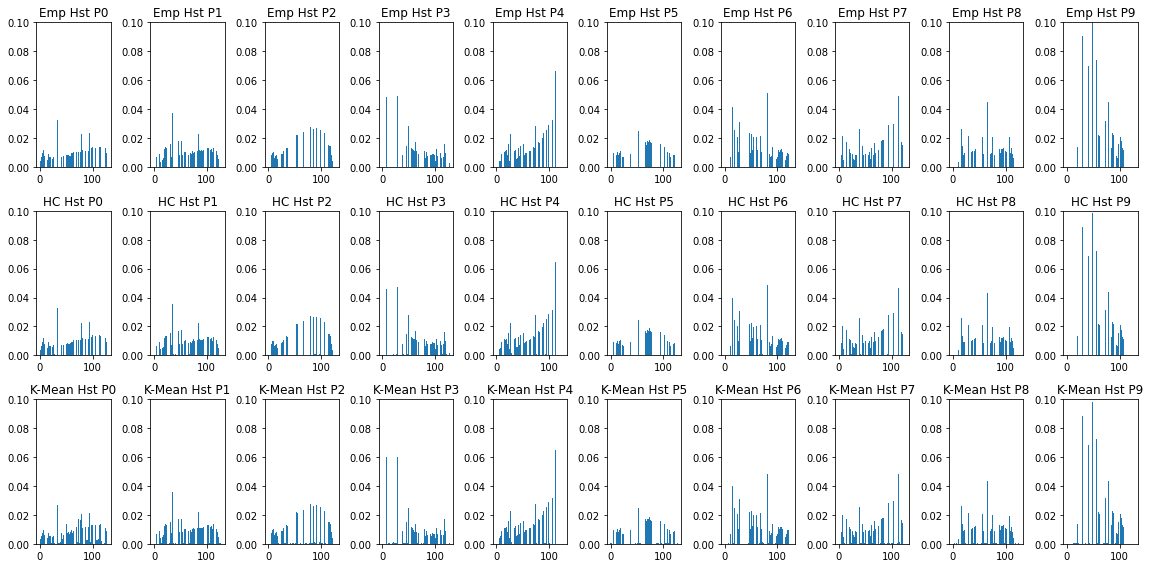

In [119]:
fig, axs = plt.subplots(nrows=1, ncols=np.prod(patch_grid_shape), figsize=(16,4))

for patch, ax in zip(range(np.prod(patch_grid_shape)), axs):
    ax.imshow(patches[np.unravel_index(patch, patch_grid_shape)])
    ax.set_title("Patch " + str(patch))

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=3, ncols=np.prod(patch_grid_shape), figsize=(16,8))

for patch, ax in zip(range(np.prod(patch_grid_shape)), axs.T):
    ax[0].bar(range(0, HC.n_bins), hists[patch][1])
    ax[0].set_ylim((0,0.1))
    ax[0].set_title("Emp Hst " + "P"+ str(patch))
    
    ax[1].bar(range(0, HC.n_bins), hists[patch][2])
    ax[1].set_ylim((0,0.1))
    ax[1].set_title("HC Hst "+ "P"+ str(patch))
    
    ax[2].bar(range(0, HC.n_bins), hists[patch][3])
    ax[2].set_ylim((0,0.1))
    ax[2].set_title("K-Mean Hst " + "P" + str(patch))

plt.tight_layout()
plt.show()


<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [379]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture, perm_texture)
check_is_fitted(HC, ["cluster_centers"])

CPU times: user 7min 12s, sys: 2min 58s, total: 10min 10s
Wall time: 8min 2s


<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. Describe what you observe.
        </li>
    </ul>

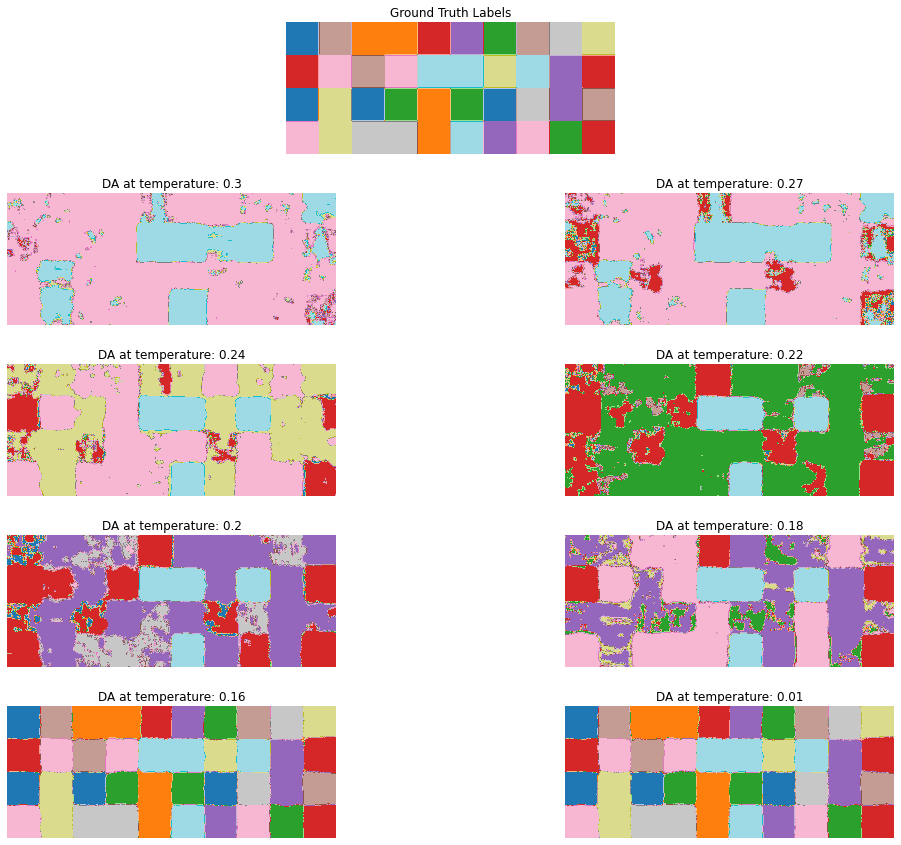

DA Train Accuracy: 97.94 %


In [421]:
fig = plt.figure(figsize=(20, 15), facecolor="none")
nrows, ncols = 5, 2
gs = GridSpec(nrows=nrows, ncols=ncols, height_ratios=[1, 1, 1, 1, 1], width_ratios=[1, 1], hspace=0.3, wspace = 0)

ax1 = fig.add_subplot(gs[0, :])
ax1.imshow(perm_label_map, cmap="tab20", aspect="equal")
ax1.set_title("Ground Truth Labels")
ax1.axis('off')

titles = HC.temperatures
images = HC.imglabels

for i in range(1, nrows * ncols):
    if i-1 < len(images):
        if (i+1)%ncols == 0:
            ax = fig.add_subplot(gs[i//ncols+1, (i+1)%ncols])
        else:
            ax = fig.add_subplot(gs[i//ncols, (i+1)%ncols])
        ax.imshow(images[i-1], cmap="tab20", aspect="equal")
        ax.set_title("DA at temperature: " + str(round(titles[i-1], 2)))
        ax.axis('off')

plt.show()


print('DA Train Accuracy:', round(accuracy_score(perm_label_map.flatten(), HC.imglabels[-1].flatten()), 4)*100, "%")

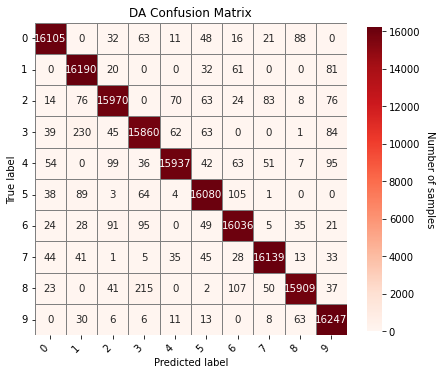

In [422]:
plot_confusion_matrix(perm_label_map.flatten(), HC.imglabels[-1].flatten(), title ="DA Confusion Matrix")

From the results above we can see that the DA algorithm reaches similiar performance to both the K-Means algorithm and the MAP algorithm.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.